# Libraries

In [14]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
from keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2,ResNet50
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, LSTM, Dense, BatchNormalization, Dropout, Flatten, MaxPooling2D

In [15]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

# Data

## Load and Transform Data

In [16]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [54]:
base_dir = r"C:\Users\user\Documents\Datasets\facial_emotion_dataset\dataset"

## Count data and Classes

Number of classes in Train directory folder: 5


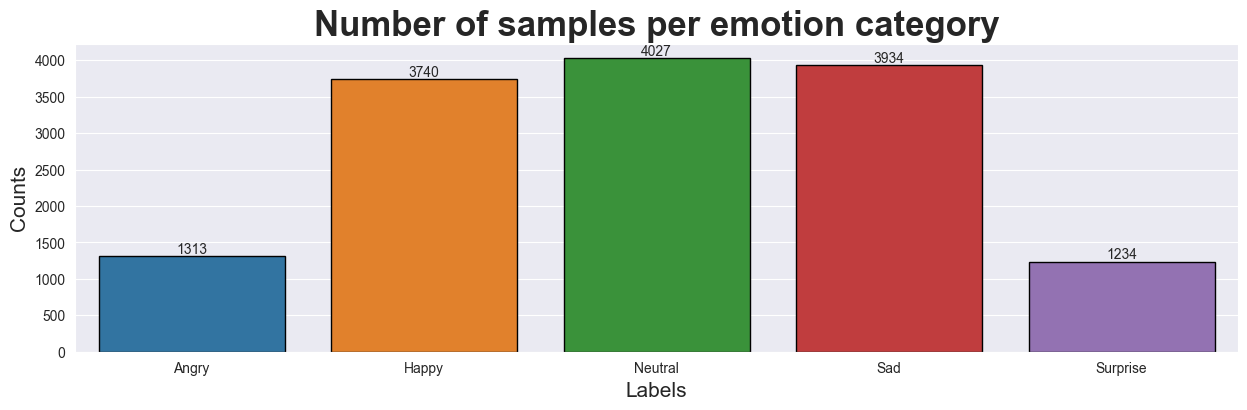

In [58]:
def num_of_classes(folder_dir, folder_name):
    classes = [class_name for class_name in os.listdir(base_dir)]
    print(colored(f'Number of classes in {folder_name} folder: {len(classes)}', 'blue', attrs=['bold']))
num_of_classes(base_dir, 'Train directory')

classes = [class_name for class_name in os.listdir(base_dir)]
count = []

for class_name in classes:
    count.append(len(os.listdir(os.path.join(base_dir, class_name))))

plt.figure(figsize = (15, 4))
ax = sns.barplot(x = classes, y = count, hue = classes, edgecolor = 'black')
for i in ax.containers:
    ax.bar_label(i, )
plt.title('Number of samples per emotion category', fontsize = 25, fontweight = 'bold')
plt.xlabel('Labels', fontsize = 15)
plt.ylabel('Counts', fontsize = 15)
plt.show()

## Converting data into Dataframe

In [61]:
def create_df(folder_path):
    all_image = []
    for class_name in classes:
        class_path = os.path.join(folder_path, class_name)
        all_image.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
    df = pd.DataFrame(all_image, columns=['file_path', 'label']) 
    return df  

dataset = create_df(base_dir)

#Making training and validation dataset
train_dataset, validation_dataset = train_test_split(dataset, test_size=0.2, random_state=0)
validation_dataset, test_dataset = train_test_split(validation_dataset, test_size=0.5, random_state=0)

print(colored(f'Number of samples in training dataset: {len(train_dataset)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples in validation dataset: {len(validation_dataset)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples in testing dataset: {len(test_dataset)}', 'blue', attrs=['bold']))

Number of samples in training dataset: 11398
Number of samples in validation dataset: 1425
Number of samples in testing dataset: 1425


## Show images per class label

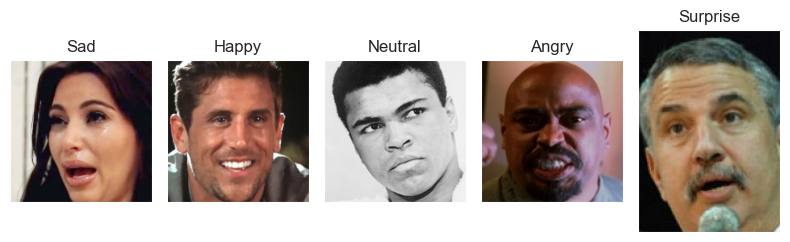

In [62]:
df_unique = train_dataset.copy().drop_duplicates(subset=['label']).reset_index()

fig, axes = plt.subplots(1, 5, figsize = (8, 7),
                         subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.file_path[i]))
    ax.set_title(df_unique.label[i], fontsize = 12)
plt.tight_layout()
plt.show()

## Data Generator

Train Generator

In [63]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.1,
    horizontal_flip = True,
    shear_range = 0.1,
    fill_mode = 'nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_dataset,
    x_col = 'file_path',
    y_col = 'label',
    targe_size = TARGET_SIZE,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42
)

Found 11398 validated image filenames belonging to 5 classes.


Validation generator

In [64]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe = validation_dataset,
    x_col = 'file_path',
    y_col = 'label',
    target_size = (224, 224),
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    seed = 42,
    shuffle = False
)

Found 1425 validated image filenames belonging to 5 classes.


Test Generator

In [65]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_dataset,
    x_col = 'file_path',
    y_col = 'label',
    target_size = TARGET_SIZE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    seed = 42,
    shuffle = False
)

Found 1425 validated image filenames belonging to 5 classes.


# Modeling

In [66]:
pre_trained_model = MobileNetV2(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet',
    pooling = 'avg'
)

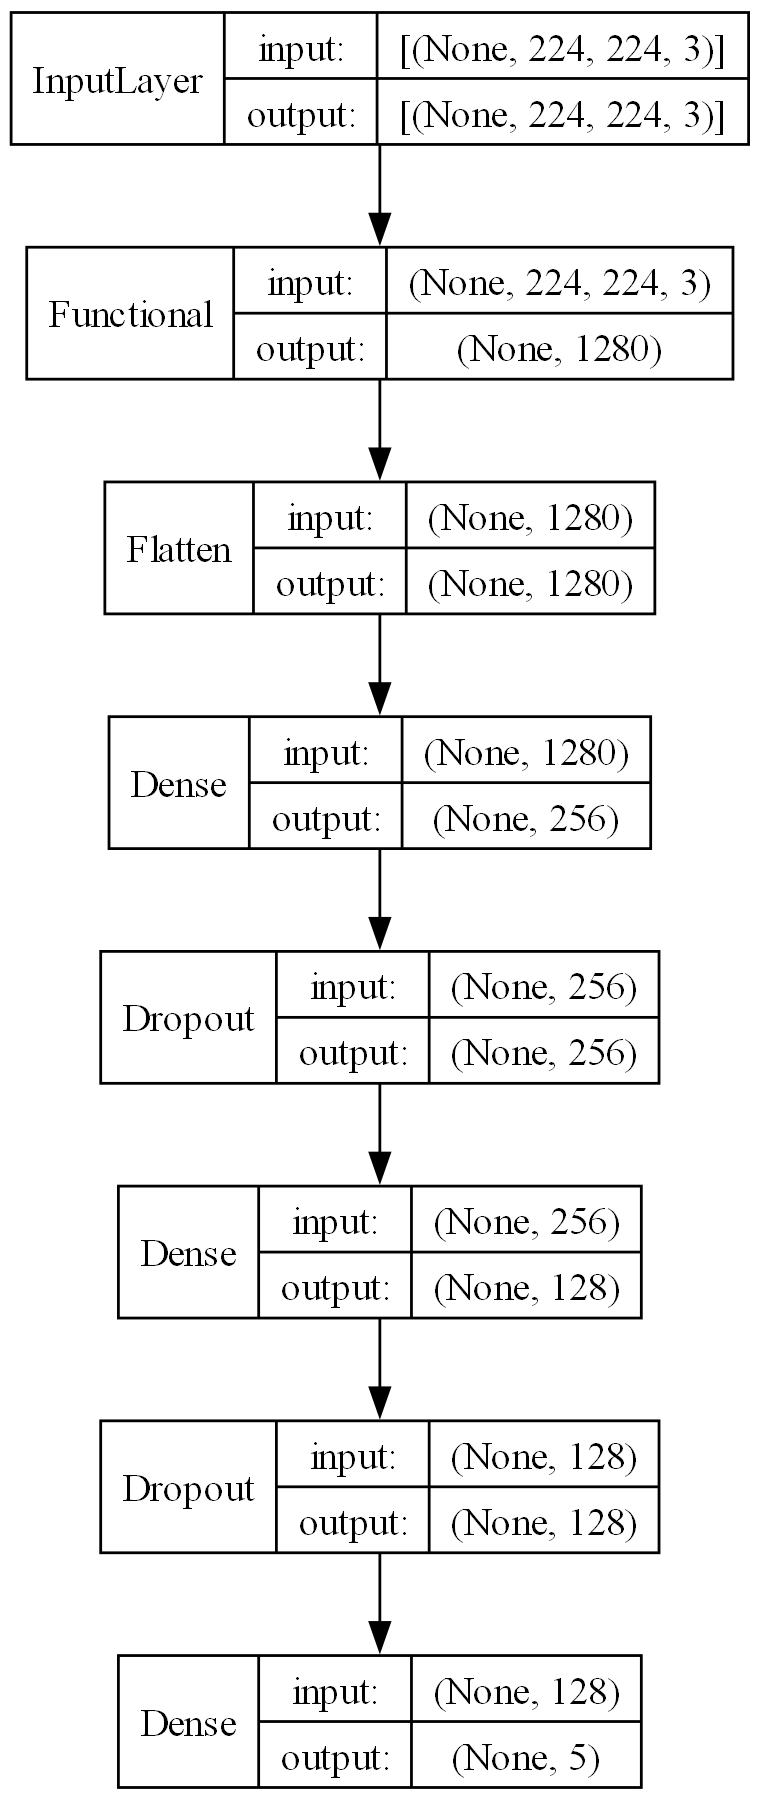

In [67]:
model = models.Sequential()
model.add(pre_trained_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(5, activation = 'softmax'))
plot_model(model, show_shapes=True, show_layer_names=False, dpi = 200)

In [68]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               327936    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                      

In [69]:
model.compile(optimizer = optimizers.Adam(learning_rate=0.001),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [70]:
# Model CheckPoint
checkpoint_cb = ModelCheckpoint('MyModel.keras', save_best_only=True)

# Early Stopping
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLRonPlateau
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3, min_lr = 1e-6)

# Training

In [71]:
history = model.fit(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs = 50,
    validation_data = validation_generator,
    validation_steps = len(validation_generator),
    callbacks = [checkpoint_cb, earlystop_cb, reduce_lr]
)

Epoch 1/50
357/357 [==============================] - 144s 392ms/step - loss: 0.9190 - accuracy: 0.6355 - val_loss: 6.1365 - val_accuracy: 0.3060 - lr: 0.0010
Epoch 2/50
357/357 [==============================] - 148s 414ms/step - loss: 0.6769 - accuracy: 0.7420 - val_loss: 6.0791 - val_accuracy: 0.3516 - lr: 0.0010
Epoch 3/50
357/357 [==============================] - 144s 404ms/step - loss: 0.6137 - accuracy: 0.7681 - val_loss: 3.0890 - val_accuracy: 0.3909 - lr: 0.0010
Epoch 4/50
357/357 [==============================] - 147s 411ms/step - loss: 0.5696 - accuracy: 0.7871 - val_loss: 8.0556 - val_accuracy: 0.2786 - lr: 0.0010
Epoch 5/50
357/357 [==============================] - 144s 402ms/step - loss: 0.5573 - accuracy: 0.7906 - val_loss: 6.1879 - val_accuracy: 0.2723 - lr: 0.0010
Epoch 6/50
357/357 [==============================] - 147s 410ms/step - loss: 0.5145 - accuracy: 0.8034 - val_loss: 4.1727 - val_accuracy: 0.3004 - lr: 0.0010
Epoch 7/50
357/357 [==========================

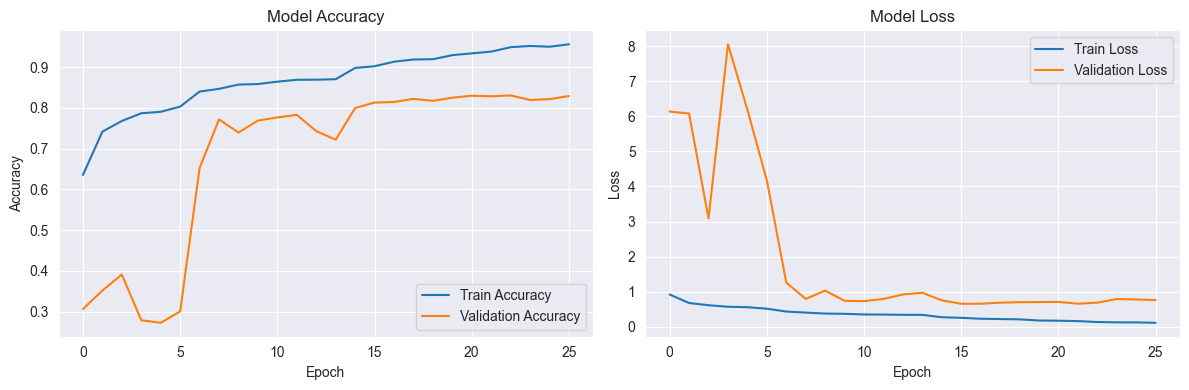

In [73]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

45/45 [==============================] - 7s 122ms/step


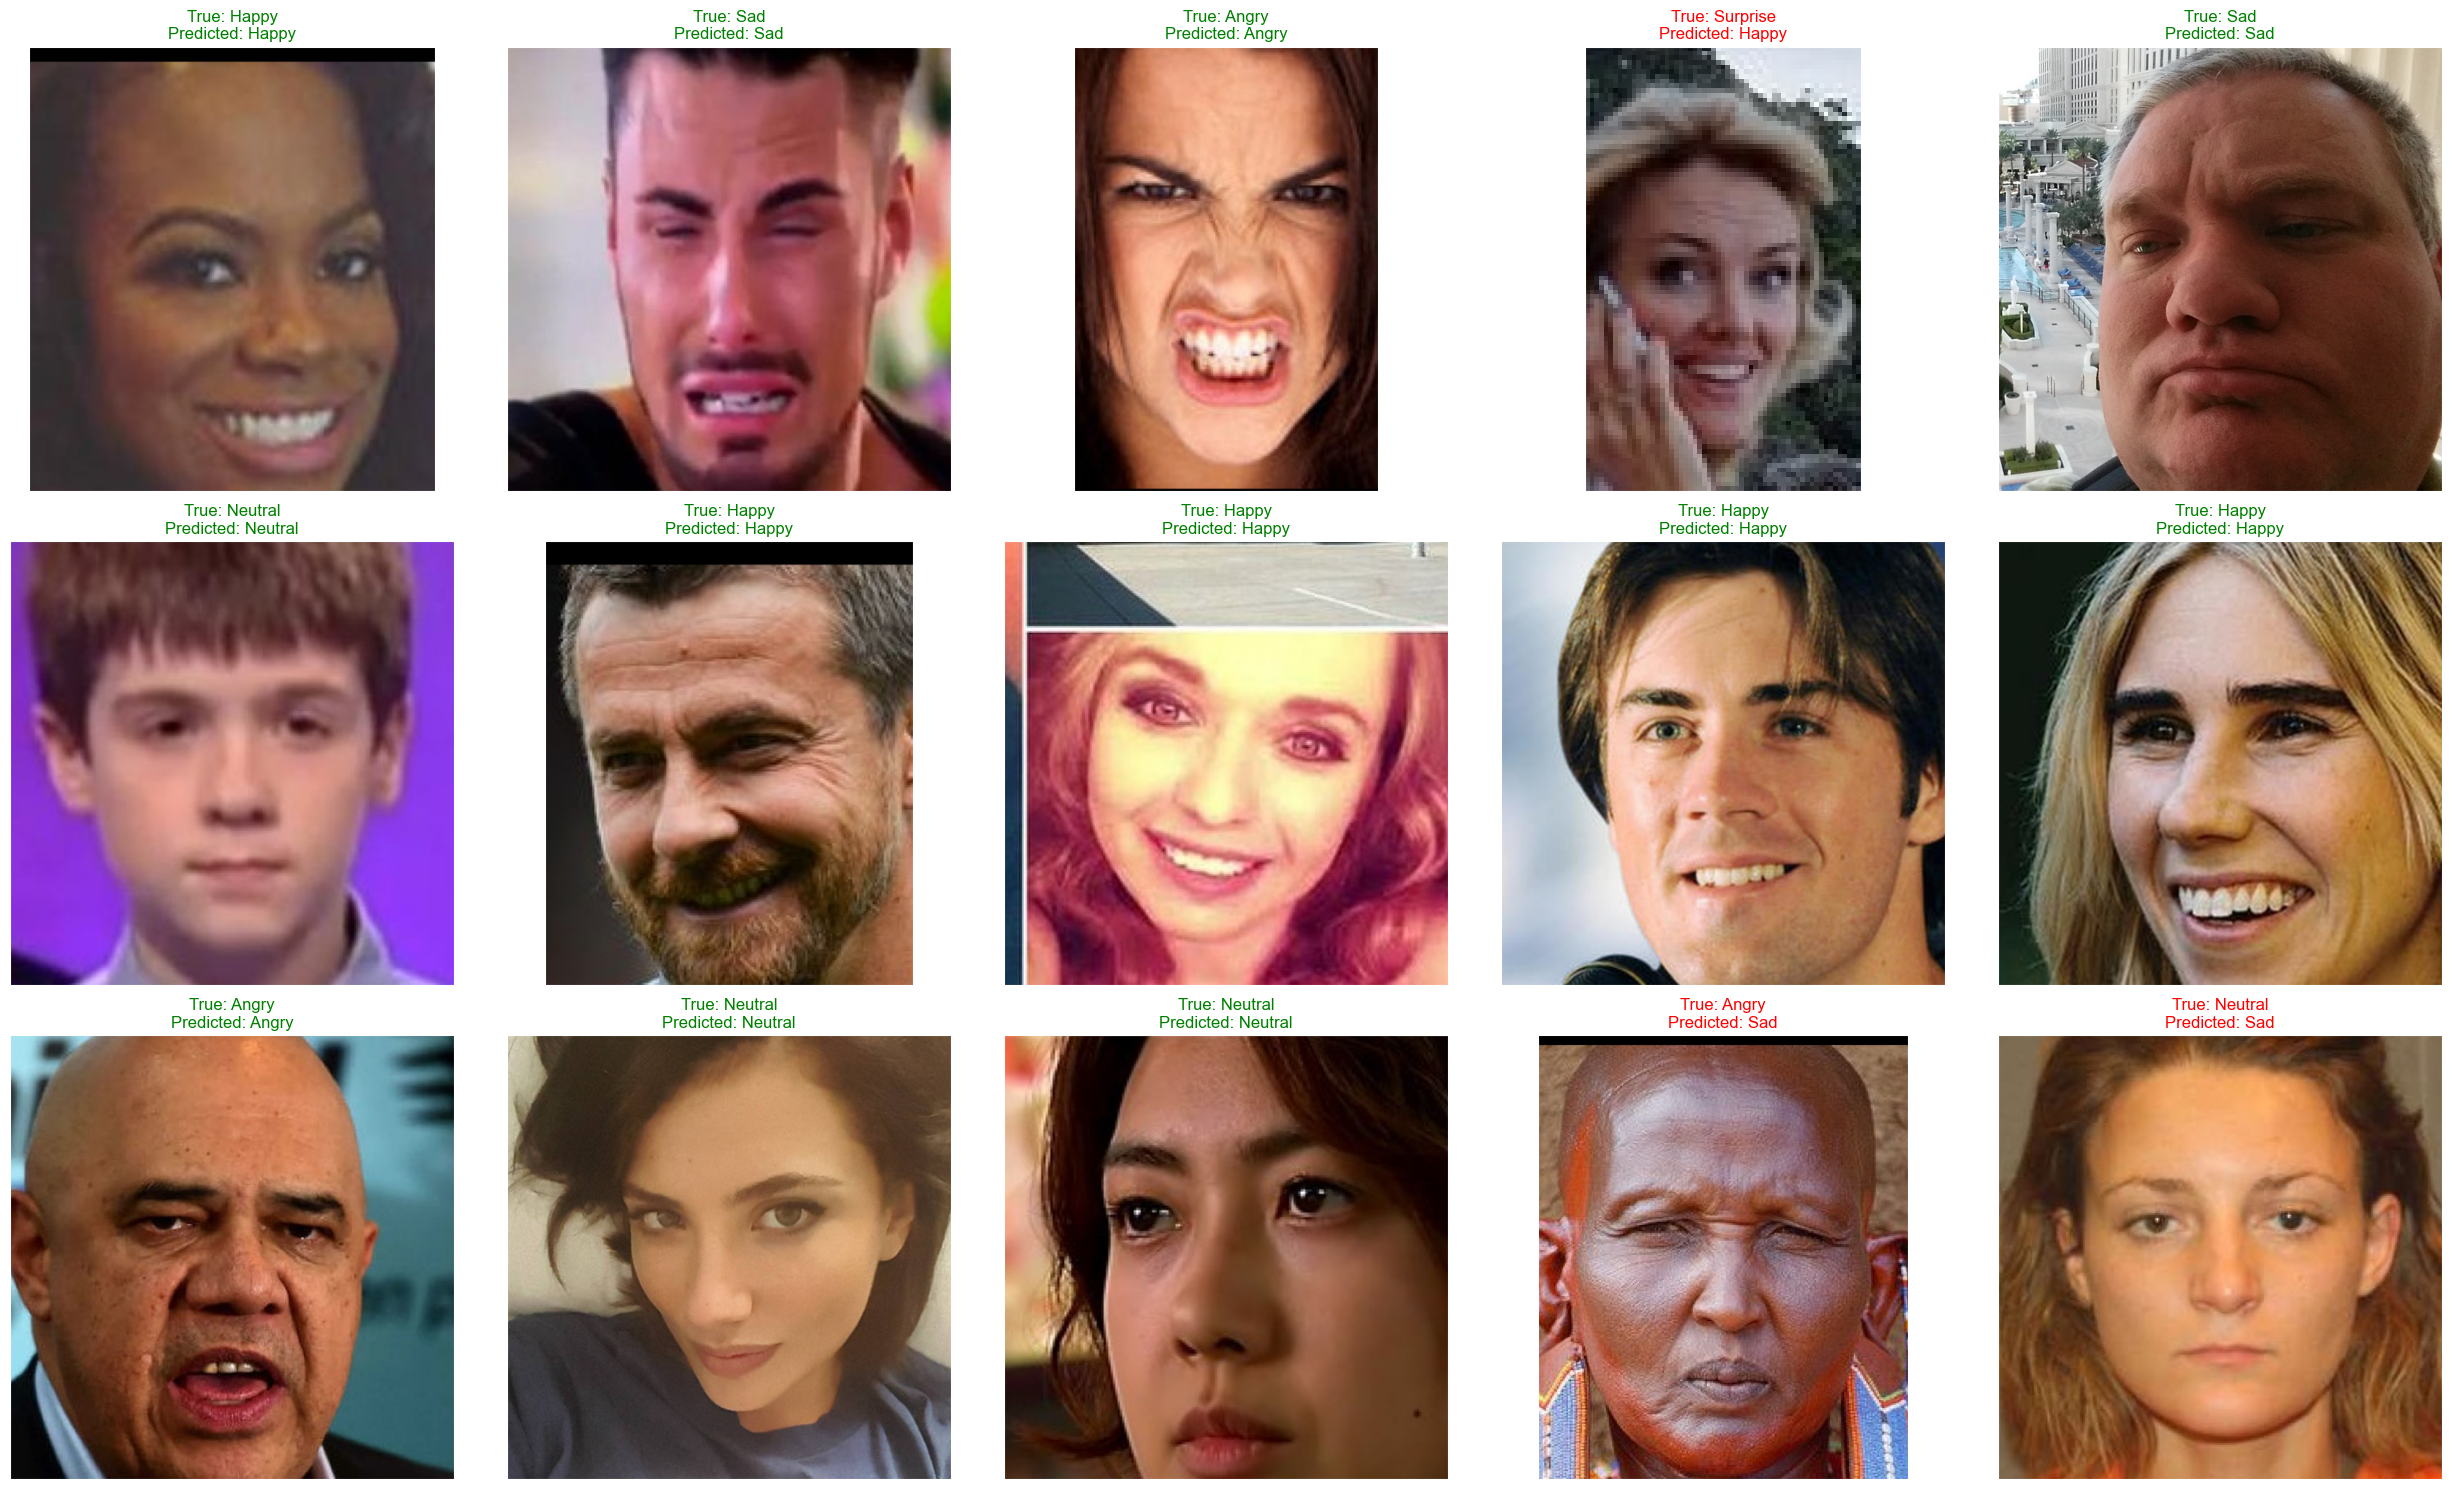

In [74]:
num_images = len(test_dataset)  # Assuming `test_dataset` is a pandas DataFrame with the test data

class_labels = list(validation_generator.class_indices.keys())

# Getting all the true labels for the validation set
true_labels = test_generator.classes

# To get the predicted labels, we predict using the model  
predictions = model.predict(test_generator, steps=len(test_generator))

# Take the argmax to get the predicted class indices.
predicted_labels = np.argmax(predictions, axis=1)

random_index = np.random.randint(0, len(test_dataset) - 1, num_images)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                             subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
        # Replace 'file_path' and 'class_label' with the correct column names for image paths and labels
        img_path = test_dataset['file_path'].iloc[random_index[i]]
        true_label = test_dataset['label'].iloc[random_index[i]]
        
        # Get the predicted class index and map it to the class name
        pred_index = predicted_labels[random_index[i]]
        pred_label = class_labels[pred_index]  # Convert the index to the class name

        # Display the image
        ax.imshow(plt.imread(img_path))
        
        # Determine the color of the title based on prediction accuracy
        if true_label == pred_label:
            color = "green"
        else:
            color = "red"
        
        # Set title showing true and predicted class names
        ax.set_title(f"True: {true_label}\nPredicted: {pred_label}", color=color)
    
plt.tight_layout()
plt.show()

In [75]:
model.save('facial_expression.h5')

In [76]:
class_label = list(train_generator.class_indices.keys())
class_labels

['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']